## Objective

The purpose of this notebook is to load, clean, and validate historical soybean production data in Argentina.
This step ensures data consistency and quality before storage and further analysis.

## Dataset Structure

The dataset contains **12,470 records** covering soybean production in Argentina from **1941 to 2024**.

Main variables:
- Crop information
- Temporal data (year and campaign)
- Geographical hierarchy (province and department)
- Agricultural indicators (surface area, production, yield)



In [30]:
import pandas as pd


df = pd.read_csv("soja_produccion.csv")
df.head()

,cultivo_nombre,anio,campania,provincia_nombre,provincia_id,departamento_nombre,departamento_id,superficie_sembrada_ha,superficie_cosechada_ha,produccion_tm,rendimiento_kgxha
0,soja,1941,1941/1942,Misiones,54,Cainguás,54014,300,200,140,700
1,soja,1941,1941/1942,Misiones,54,Candelaria,54021,100,100,100,1000
2,soja,1941,1941/1942,Misiones,54,Iguazú,54063,70,70,56,800
3,soja,1941,1941/1942,Misiones,54,San Ignacio,54098,100,100,70,700
4,soja,1941,1941/1942,Misiones,54,San Javier,54105,30,30,15,500


### Key Columns Description

- `anio`: Calendar year of production
- `campania`: Agricultural campaign (e.g., 2014/2015)
- `provincia_nombre`: Province name
- `departamento_nombre`: Department name
- `superficie_sembrada_ha`: Sown surface area (hectares)
- `superficie_cosechada_ha`: Harvested surface area (hectares)
- `produccion_tm`: Total production in metric tons
- `rendimiento_kgxha`: Yield in kilograms per hectare

#Data Exploration

In [31]:
df['anio'].min(), df['anio'].max()

(1941, 2024)

In [32]:
df.isnull().sum()

,0
cultivo_nombre,0
anio,0
campania,0
provincia_nombre,0
provincia_id,0
departamento_nombre,0
departamento_id,0
superficie_sembrada_ha,0
superficie_cosechada_ha,0
produccion_tm,0


In [33]:
df.describe()

,anio,provincia_id,departamento_id,superficie_sembrada_ha,superficie_cosechada_ha,produccion_tm,rendimiento_kgxha
count,12602.000000,12602.000000,12602.000000,12602.000000,12602.000000,1.260200e+04,12602.000000
mean,1998.070227,33.815585,34014.858118,41559.925647,40337.633868,1.049338e+05,2017.205206
std,17.783621,30.255106,30138.159652,81347.533402,79792.825093,2.338435e+05,825.721156
min,1941.000000,6.000000,6007.000000,0.000000,0.000000,0.000000e+00,0.000000
25%,1985.000000,6.000000,6651.000000,700.000000,600.000000,1.020000e+03,1463.250000
50%,2000.000000,22.000000,22049.000000,7000.000000,6650.000000,1.280000e+04,2000.000000
75%,2013.000000,54.000000,54112.000000,46414.750000,44000.000000,9.877275e+04,2548.000000
max,2024.000000,90.000000,90119.000000,894613.000000,883613.000000,2.637503e+06,20000.000000


In [34]:
df[df['superficie_sembrada_ha'] <= 0].shape
df[df['superficie_cosechada_ha'] < 0].shape

(0, 11)

#Data Quality

### Agronomic Logic Validation: Surface Area Inconsistency
We identify records where the harvested area exceeds the sown area. This scenario violates basic agricultural logic and indicates data entry errors.

In [35]:
df[df['superficie_cosechada_ha'] > df['superficie_sembrada_ha']].shape

(1, 11)

In [36]:
inconsistente = df[
    df['superficie_cosechada_ha'] > df['superficie_sembrada_ha']
]

inconsistente

,cultivo_nombre,anio,campania,provincia_nombre,provincia_id,departamento_nombre,departamento_id,superficie_sembrada_ha,superficie_cosechada_ha,produccion_tm,rendimiento_kgxha
544,soja,1967,1967/1968,Corrientes,18,Santo Tomé,18168,350,390,320,821


###Data Integrity: Null Production with Active Harvest
Searching for anomalies where a harvested area is reported but total production remains zero. These records are inconsistent and will be flagged for removal to maintain dataset quality.


In [37]:
df[
    (df['produccion_tm'] == 0) &
    (df['superficie_cosechada_ha'] > 0)
].shape

(5, 11)

### Statistical Outlier Detection: Biological Yield Limits
Analyzing the distribution of yields. A maximum value of 20,000 kg/ha (20 tons) is detected, which is biologically impossible for soybean crops and represents a clear statistical outlier.

In [38]:
df['rendimiento_kgxha'].describe()

,rendimiento_kgxha
count,12602.000000
mean,2017.205206
std,825.721156
min,0.000000
25%,1463.250000
50%,2000.000000
75%,2548.000000
max,20000.000000


<Axes: >

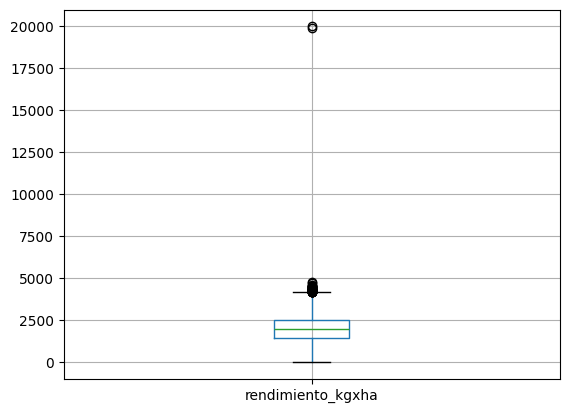

In [39]:
df.boxplot(column='rendimiento_kgxha')

# Data Cleansing

In [40]:

df_clean = df.copy()
df_clean = df_clean[
    df_clean['superficie_cosechada_ha'] <= df_clean['superficie_sembrada_ha']
]

df_clean = df_clean[
    ~(
        (df_clean['produccion_tm'] == 0) &
        (df_clean['superficie_cosechada_ha'] > 0)
    )
]

upper_yield = df_clean['rendimiento_kgxha'].quantile(0.99)
df_clean = df_clean[df_clean['rendimiento_kgxha'] <= upper_yield]

#Data Validation & Export

In [41]:
print(df.shape)
print(df_clean.shape)

(12602, 11)
(12470, 11)


In [42]:
df_clean.to_csv(
    "soja_produccion_clean.csv",
    index=False
)